## Implemention of [*ADVERSARIAL MANIPULATION OF DEEP REPRESENTATIONS*](https://arxiv.org/abs/1511.05122)
The paper's code uses caffe and caffenet to achieve. Here is the code implemented by pytorch 

In [1]:
import torch
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
import PIL
import cv2
import matplotlib.pyplot as plt
import alex
from numpy import array, asarray, float64, int32, zeros

## AlexNet and Transformer for ImageNet

In [2]:
#Altered alextnet
model = alex.alexnet(pretrained=True).cuda()
model.eval()

trans_mean = [0.485, 0.456, 0.406]
trans_std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=trans_mean,std=trans_std)
data_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize
])

## Input Data and Show

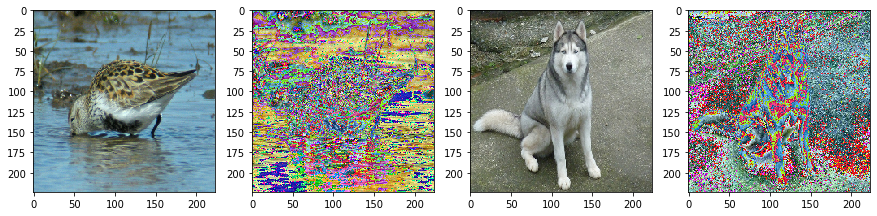

picture1 predict result is 140
picture2 predict result is 248


In [3]:
def cv2read224(filename):
    img = cv2.imread(filename) 
    img = cv2.resize(img, (224, 224))
    return img

start_image = '1.JPEG'
targe_image = '2.JPEG'
plt.figure(figsize=(15,15))
plt.subplot(141)
img = cv2read224(start_image) 
img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.imshow(img)

plt.subplot(142)
img = data_transformer(img)
img1_model = img.clone()
img1 = transforms.ToPILImage()(img).convert('RGB')
plt.imshow(img1)

plt.subplot(143)
img2 = cv2read224(targe_image) 
img2 = Image.fromarray(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))         
plt.imshow(img2)

plt.subplot(144)
img2 = data_transformer(img2)
img_model = img2.clone()
img2 = transforms.ToPILImage()(img2).convert('RGB')
plt.imshow(img2)
plt.show()

img_model = torch.unsqueeze(img_model, 0).cuda()
img1_model = torch.unsqueeze(img1_model, 0).cuda()
# print(img2.shape)
model.eval()
output,_,_,_ = model(img1_model)
pred_result = output.argmax(1, keepdim=True).item()
print("picture1 predict result is",pred_result)
output,_,_,_ = model(img_model)
pred_result = output.argmax(1, keepdim=True).item()
print("picture2 predict result is",pred_result)
target = pred_result

## Raw Data and $\delta$ Using For Constraint

In [4]:
originImage = cv2read224(start_image) 
originImage = Image.fromarray(cv2.cvtColor(originImage,cv2.COLOR_BGR2RGB))

guideImage = cv2read224(targe_image) 
guideImage = Image.fromarray(cv2.cvtColor(guideImage,cv2.COLOR_BGR2RGB))

base_img = np.array(originImage)
deta=10 

upper = base_img+deta
upper = Image.fromarray(upper)
upper = data_transformer(upper)
lower = base_img-deta
lower = Image.fromarray(lower)
lower = data_transformer(lower) 

## Objective Function:  $I_{\alpha}=\arg\mathop{\min}\limits_{I}||\phi_k(I)-\phi_k(I_g)||^2_2$
fmin_l_bfgs_b is easier to achieve constrained optimization

In [5]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        self.iter = 0
    def loss(self, x):   
        #x is the new I
        Ix=Variable(torch.from_numpy(x.reshape(Ig_input.shape)).cuda().float())
        Ix.requires_grad = True
        
        output,feat_x,_,_ = model(Ix)
        loss = torch.dist(feat_x,feat_k_guide,p=2)# minimize \\ q(I）-q(Ig)\\ , feat_k_guide is q(Ig)
        loss.backward(retain_graph=True)
        
        self.loss_value = loss
        self.grad_values = Ix.grad.cpu().numpy().flatten().astype(float)
        
        if(self.iter%200==0):
            pred_result=output.argmax(1, keepdim=True).item()
            print("iter:{},loss：{},predict：{}".format(self.iter,self.loss_value,pred_result))
        self.iter+=1
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [6]:
# subject to deta
max_img=upper.flatten()
min_img=lower.flatten()
n, = min_img.shape
constraint = []
for i in range(n):
    if(min_img[i]>max_img[i]):
        temp = min_img[i]
        min_img[i] = max_img[i]
        max_img[i] = temp
    bound = (min_img[i],max_img[i])
    constraint.append(bound)
    
# data
Is = data_transformer(originImage)
Ig = data_transformer(guideImage)

Ig_input = torch.unsqueeze(Ig, 0)
_,feat_k_guide,_,_ = model(Ig_input.cuda())#The output of model like x_final,x_fc7,x_c3,x_p. Can be found in alex.py
    
x_img=originImage.copy()
evaluator=Evaluator()
x, min_val, info = fmin_l_bfgs_b(evaluator.loss
                                 ,Is.flatten()
                                 ,bounds=constraint
                                 ,fprime=evaluator.grads
                                 ,maxiter=2000
                                )

iter:0,loss：511.5941162109375,predict：140
iter:200,loss：21.351940155029297,predict：248
iter:400,loss：15.904550552368164,predict：248
iter:600,loss：13.919087409973145,predict：248
iter:800,loss：12.865511894226074,predict：248
iter:1000,loss：12.321414947509766,predict：248
iter:1200,loss：12.008336067199707,predict：248
iter:1400,loss：11.801248550415039,predict：248
iter:1600,loss：11.64013385772705,predict：248
iter:1800,loss：11.507619857788086,predict：248
iter:2000,loss：11.402837753295898,predict：248


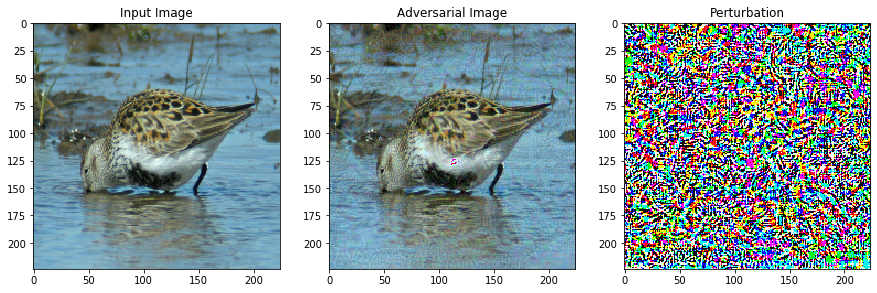

predict result is 248
attack success


In [7]:
t_mean = torch.FloatTensor(trans_mean).view(3,1,1).expand(3, 224, 224)
t_std = torch.FloatTensor(trans_std).view(3,1,1).expand(3, 224, 224)
def show3(ori,adv):
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title('Input Image')
    ori = ori.cpu()
    ori = ori* t_std +t_mean
    img1 = transforms.ToPILImage()(ori).convert('RGB')
    plt.imshow(img1)
    
    plt.subplot(132)
    plt.title('Adversarial Image')
    adv = torch.from_numpy(adv.reshape(Is.shape).astype(np.float32))
    adv_img = torch.squeeze(adv, 0)  
    adv_img = adv_img* t_std +t_mean
    diff = adv_img-ori
    adv_img = transforms.ToPILImage()(adv_img).convert('RGB')
    plt.imshow(adv_img)
    
    Pert = transforms.ToPILImage()(diff).convert('RGB')
    plt.subplot(133)
    plt.title('Perturbation')
    plt.imshow(Pert)
    plt.show()
       
output = x.copy()
show3(Is,output)

img_adv = output
img_adv = torch.from_numpy(img_adv.reshape(Is.shape).astype(np.float32)) 
img_adv = img_adv* t_std +t_mean
img_adv_temp = transforms.ToPILImage()(img_adv).convert('RGB')
img_adv = data_transformer(img_adv_temp)
img_adv = torch.unsqueeze(img_adv, 0).cuda()
output,_,_,_ = model(img_adv)
pred_result=output.argmax(1, keepdim=True).item()
print("predict result is",pred_result)
if(target==pred_result):
    print("attack success")

You can find the corresponding labels at [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)